In [1]:
%matplotlib inline

import os
from time import time
import numpy as np
import pandas as pd

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, log_loss
from scipy.stats import randint as sp_randint
from scipy import interp

import matplotlib.pyplot as plt

np.set_printoptions(formatter={'float': '{: 0.3f}'.format})

## PLOT PROPERTIES
plt.style.use('ggplot')
plt.rcParams['figure.facecolor'] = '#ffffff'
plt.rcParams['axes.facecolor'] = '#ffffff'
plt.rcParams['axes.edgecolor'] = '#000000'
plt.rcParams["savefig.facecolor"] = '#ffffff'
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False
plt.rcParams["xtick.top"] = False
plt.rcParams["ytick.right"] = False

# data directory
DATA_DIR = os.path.join('..', 'data', 'processed')

In [2]:
# Standardize features
def standardize(df, numeric_only=True):
    numeric = df.select_dtypes(include=['int64', 'float64'])
    
    # subtract by mean and divide by std
    df[numeric.columns] = (numeric - numeric.mean()) / numeric.std()
    
    return df
    
## Pre Process Data - Convert the Categoricals and Standardize Numbers
def pre_process_data(df, enforce_cols=None):
    print("Input shape:\t{}".format(df.shape))
        

    df = standardize(df)
    print("After standardization {}".format(df.shape))
        
    # create dummy variables for categoricals
    df = pd.get_dummies(df)
    print("After converting categoricals:\t{}".format(df.shape))
    

    # match test set and training set columns
    if enforce_cols is not None:
        to_drop = np.setdiff1d(df.columns, enforce_cols)
        to_add = np.setdiff1d(enforce_cols, df.columns)

        df.drop(to_drop, axis=1, inplace=True)
        df = df.assign(**{c: 0 for c in to_add})
    
    df.fillna(0, inplace=True)
    
    return df

## Train a RandomForest Classifier
def train_model(features, labels, **kwargs):
    
    # instantiate model
    model = RandomForestClassifier(n_estimators=50, random_state=0)
    
    # train model
    model.fit(features, labels)
    
    # get a (not-very-useful) sense of performance
    accuracy = model.score(features, labels)
    print "In-sample accuracy: %0.2f"%(accuracy)
    
    return model

## Make Submission DataFrame
def make_country_sub(preds, test_feat, country):
    # make sure we code the country correctly
    country_codes = ['A', 'B', 'C']
    
    # get just the poor probabilities
    country_sub = pd.DataFrame(data=preds[:, 1],  # proba p=1
                               columns=['poor'], 
                               index=test_feat.index)

    
    # add the country code for joining later
    country_sub["country"] = country
    return country_sub[["country", "poor"]]

# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

##### Household-level survey data: 
This is obfuscated data from surveys conducted by The World Bank, focusing on household-level statistics. The data come from three different countries, and are separated into different files for convenience.

##### Individual-level survey data: 
This is obfuscated data from related surveys conducted by The World Bank, only these focus on individual-level statistics. The set of interviewees and countries involved are the same as the household data, as indicated by shared id indices, but this data includes detailed (obfuscated) information about household members.

##### Submission format:
This gives us the filenames and columns of our submission prediction, filled with all 0.5 as a baseline.

In [3]:
## define data paths
data_paths = {'A': {'train': os.path.join(DATA_DIR, 'A', 'A_hhold_train.csv'), 
                    'test':  os.path.join(DATA_DIR, 'A', 'A_hhold_test.csv')}, 
              
              'B': {'train': os.path.join(DATA_DIR, 'B', 'B_hhold_train.csv'), 
                    'test':  os.path.join(DATA_DIR, 'B', 'B_hhold_test.csv')}, 
              
              'C': {'train': os.path.join(DATA_DIR, 'C', 'C_hhold_train.csv'), 
                    'test':  os.path.join(DATA_DIR, 'C', 'C_hhold_test.csv')}}

In [4]:
# load training data
a_train = pd.read_csv(data_paths['A']['train'], index_col='id')
b_train = pd.read_csv(data_paths['B']['train'], index_col='id')
c_train = pd.read_csv(data_paths['C']['train'], index_col='id')
# a_train.head()

#### The first thing to notice is that each country's surveys have wildly different numbers of columns, so we'll plan on training separate models for each country and combining our predictions for submission at the end.

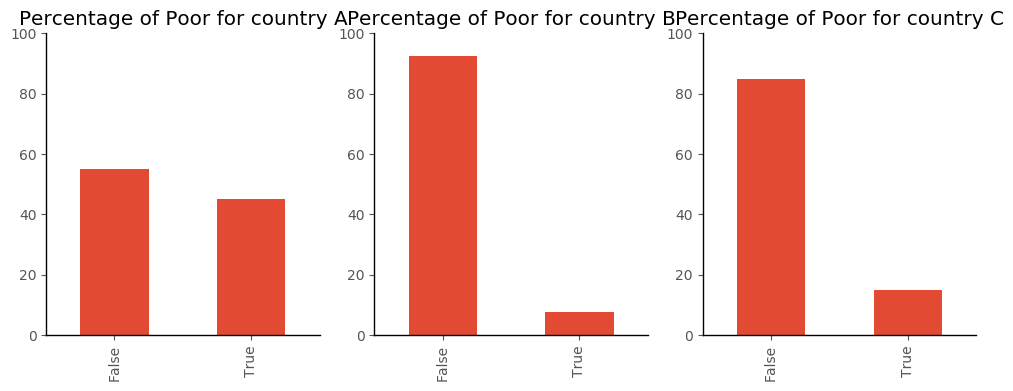

In [5]:
f, ax = plt.subplots(1, 3, figsize=(12,4), dpi=100, facecolor='w', edgecolor='k')
((a_train.poor.value_counts()/a_train.poor.shape[0])*100).plot.bar(title='Percentage of Poor for country A', ax=ax[0], ylim=(0, 100))
((b_train.poor.value_counts()/b_train.poor.shape[0])*100).plot.bar(title='Percentage of Poor for country B', ax=ax[1], ylim=(0, 100))
((c_train.poor.value_counts()/c_train.poor.shape[0])*100).plot.bar(title='Percentage of Poor for country C', ax=ax[2], ylim=(0, 100))
plt.show()

In [6]:
print("Country A")
aX_train = pre_process_data(a_train.drop('poor', axis=1))
ay_train = np.ravel(a_train.poor)

print("\nCountry B")
bX_train = pre_process_data(b_train.drop('poor', axis=1))
by_train = np.ravel(b_train.poor)

print("\nCountry C")
cX_train = pre_process_data(c_train.drop('poor', axis=1))
cy_train = np.ravel(c_train.poor)

Country A
Input shape:	(8203, 344)
After standardization (8203, 344)
After converting categoricals:	(8203, 859)

Country B
Input shape:	(3255, 441)
After standardization (3255, 441)
After converting categoricals:	(3255, 1432)

Country C
Input shape:	(6469, 163)
After standardization (6469, 163)
After converting categoricals:	(6469, 795)


In [7]:
# aX_train.head()

### Cross-validation

### Training Phase

In [8]:
model_a = train_model(aX_train, ay_train)
model_b = train_model(bX_train, by_train)
model_c = train_model(cX_train, cy_train)

In-sample accuracy: 1.00
In-sample accuracy: 1.00
In-sample accuracy: 1.00


### Testing Phase

In [9]:
# load test data
a_test = pd.read_csv(data_paths['A']['test'], index_col='id')
b_test = pd.read_csv(data_paths['B']['test'], index_col='id')
c_test = pd.read_csv(data_paths['C']['test'], index_col='id')

In [10]:
# process the test data
a_test = pre_process_data(a_test, enforce_cols=aX_train.columns)
b_test = pre_process_data(b_test, enforce_cols=bX_train.columns)
c_test = pre_process_data(c_test, enforce_cols=cX_train.columns)

Input shape:	(4041, 344)
After standardization (4041, 344)
After converting categoricals:	(4041, 851)
Input shape:	(1604, 441)
After standardization (1604, 441)
After converting categoricals:	(1604, 1419)
Input shape:	(3187, 163)
After standardization (3187, 163)
After converting categoricals:	(3187, 773)


In [11]:
## Predict
a_preds = model_a.predict_proba(a_test)
b_preds = model_b.predict_proba(b_test)
c_preds = model_c.predict_proba(c_test)
print a_preds[0:5]

[[ 0.680  0.320]
 [ 0.720  0.280]
 [ 0.740  0.260]
 [ 0.640  0.360]
 [ 0.740  0.260]]


In [12]:
# convert preds to data frames
a_sub = make_country_sub(a_preds, a_test, 'A')
b_sub = make_country_sub(b_preds, b_test, 'B')
c_sub = make_country_sub(c_preds, c_test, 'C')

In [13]:
submission = pd.concat([a_sub, b_sub, c_sub])
print submission.head()

## Submission Format
submission.to_csv('submission.csv')

      country  poor
id                 
418         A  0.32
41249       A  0.28
16205       A  0.26
97501       A  0.36
67756       A  0.26


In [14]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import cross_validate
from sklearn.metrics.scorer import make_scorer

X = aX_train.values.astype(np.float32)
y = ay_train.astype(np.int16)

## select model evaluation parameters
scoring = ['precision_macro', 'recall_macro', 'f1_weighted', 'neg_log_loss']

## select the data splitting method for cross-validation
cv = StratifiedShuffleSplit(n_splits=20, test_size=0.5, random_state=0)

## select the classifier
# clf = svm.SVC(probability=True, random_state=0)
clf = RandomForestClassifier(n_estimators=50, random_state=0)

## cross-validation
scores = cross_validate(clf, X, y, scoring=scoring, cv=cv, return_train_score=True)

## print the outcome
scoresDF = pd.DataFrame(scores)

In [15]:
# ## Feature importance
# importances = forest.feature_importances_
# std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
# indices = np.argsort(importances)[::-1]

# # Print the feature ranking
# print("Feature ranking:")

# for f in range(X.shape[1]):
#     print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# # Plot the feature importances of the forest
# plt.figure()
# plt.title("Feature importances")
# plt.bar(range(X.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
# plt.xticks(range(X.shape[1]), indices)
# plt.xlim([-1, X.shape[1]])
# plt.show()

In [40]:
## structure data
all_train_data = {'A': {'features': aX_train, 
                    'labels': ay_train},
              
              'B': {'features': bX_train, 
                    'labels':  by_train}, 
              
              'C': {'features': cX_train, 
                    'labels':  cy_train}}

## structure data
all_test_data = {'A': {'features': aX_train},
                 'B': {'features': bX_train},
                 'C': {'features': cX_train}}

In [ ]:
bestParams = []
for grp in all_data:
    
    # get some data
    X = all_train_data[grp]['features'].values.astype(np.float32)
    y = all_train_data[grp]['labels'].astype(np.int16)

    # build a classifier
    clf = RandomForestClassifier()

    # specify parameters and distributions to sample from
    param_dist = {"n_estimators": sp_randint(1, 100),
                  "max_depth": sp_randint(3, 63),
                  "max_features": sp_randint(1, 300),
                  "min_samples_split": sp_randint(2, 300),
                  "min_samples_leaf": sp_randint(1, 300),
                  "bootstrap": [True, False],
                  "criterion": ["gini", "entropy"]}

    # run randomized search
    n_iter_search = 100
    random_search = RandomizedSearchCV(clf, scoring='neg_log_loss', 
                                       param_distributions=param_dist, 
                                       n_iter=n_iter_search, cv=cv,
                                      return_train_score=False)

    start = time()
    random_search.fit(X, y)
    gridSearchScores = pd.DataFrame(random_search.cv_results_)
    gridSearchScores.sort_values(['mean_test_score'], axis=0, ascending=False, inplace=True)
    gridSearchScores.head()

    all_data[grp]['best_parameters'] = gridSearchScores.iloc[0,:]
    bestParams.append(all_data[grp]['best_parameters'])

bestParamsDF = pd.DataFrame(bestParams, index=['A', 'B', 'C'])
bestParamsDF.to_csv('bestParametersAllThreeModels.txt', sep='\t', index_label='group')
bestParams

,mean_fit_time,mean_score_time,mean_test_score,param_bootstrap,param_criterion,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,param_n_estimators,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,std_fit_time,std_score_time,std_test_score
A,2.316544,0.025559,-0.381744,False,entropy,20,285,18,89,38,...,-0.384200,-0.385390,-0.377701,-0.388662,-0.379633,-0.387202,-0.382761,0.080482,0.002057,0.004545
B,1.610688,0.020258,-0.039839,False,entropy,62,229,9,41,52,...,-0.040536,-0.040714,-0.043294,-0.041767,-0.045240,-0.036162,-0.038563,0.092780,0.002760,0.002505
C,0.564161,0.016994,-0.231095,True,entropy,49,141,17,15,59,...,-0.233170,-0.226378,-0.225476,-0.232169,-0.235651,-0.236599,-0.228529,0.009169,0.001511,0.003256


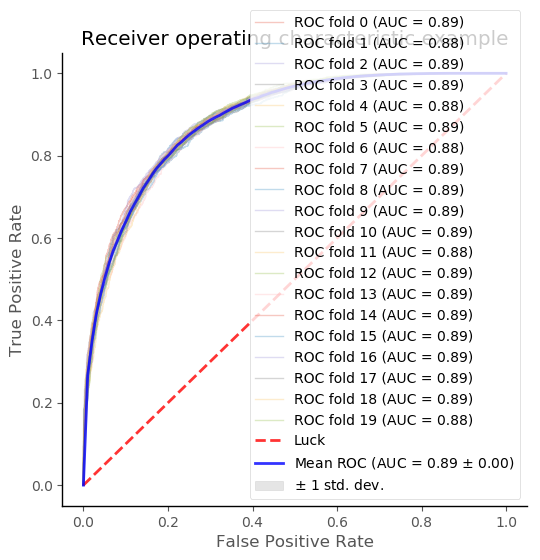

In [18]:
X = aX_train.values.astype(np.float32)
y = ay_train.astype(np.int16)

plt.figure(figsize=(6,6), dpi=100, facecolor='w', edgecolor='k')
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

## Optimized using F-score
# clf = RandomForestClassifier(bootstrap=False, min_samples_leaf=3,
#                              n_estimators=85, min_samples_split=7,
#                              criterion='entropy', max_features=10,
#                              max_depth=21)

## Optimized using Log-loss
clf = RandomForestClassifier(bootstrap=False, min_samples_leaf=1,
                             n_estimators=55, min_samples_split=8,
                             criterion='entropy', max_features=10,
                             max_depth=27)
i = 0
for train, test in cv.split(X, y):
    probas_ = clf.fit(X[train], y[train]).predict_proba(X[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
    i += 1

plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Luck', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

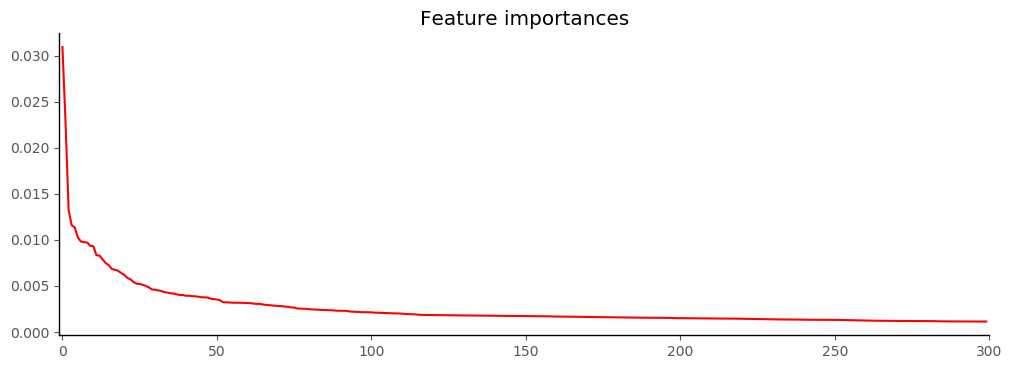

In [19]:
# ## Feature importance
importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
# print("Feature ranking:")
# for f in range(X.shape[1]):
#     print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
top_features = 300
top_indices = indices[0:top_features]
plt.figure(figsize=(12,4), dpi=100, facecolor='w', edgecolor='k')
plt.title("Feature importances")
# plt.bar(range(X.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
# plt.bar(range(0, top_features), importances[top_indices], color="r", align="center")
plt.plot(range(0, top_features), importances[top_indices], color="r")
# plt.xticks(range(0, top_features), top_indices)
plt.xlim([-1, top_features])
plt.show()

In [20]:
# # use a full grid over all parameters
# param_grid = {"max_depth": [3, None],
#               "max_features": [1, 3, 10],
#               "min_samples_split": [2, 3, 10],
#               "min_samples_leaf": [1, 3, 10],
#               "bootstrap": [True, False],
#               "criterion": ["gini", "entropy"]}

# # run grid search
# grid_search = GridSearchCV(clf, param_grid=param_grid)
# start = time()
# grid_search.fit(X, y)

# print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
#       % (time() - start, len(grid_search.cv_results_['params'])))
# report(grid_search.cv_results_)

In [38]:
## Train Model
trained_models = {}
for grp in all_data:
    trained_models[grp] = RandomForestClassifier(bootstrap=trainParamDF.loc[grp, 'param_bootstrap'],
                                     min_samples_leaf=trainParamDF.loc[grp, 'param_min_samples_leaf'],
                                     n_estimators=trainParamDF.loc[grp, 'param_n_estimators'], 
                                     min_samples_split=trainParamDF.loc[grp, 'param_min_samples_split'],
                                     criterion=trainParamDF.loc[grp, 'param_criterion'],
                                     max_features=trainParamDF.loc[grp, 'param_max_features'],
                                     max_depth=trainParamDF.loc[grp, 'param_max_depth'])
    trained_models[grp].fit(all_train_data[grp]['features'], all_train_data[grp]['labels'])

In [49]:
## Predict
predictions = {}
for grp in all_data:
    predictions[grp] = trained_models[grp].predict_proba(all_test_data[grp]['features'])

submission = pd.DataFrame(predictions['A'])

## Submission Format
# submission.to_csv('submission.csv')

In [51]:
submission

,0,1
0,0.732010,0.267990
1,0.739912,0.260088
2,0.833005,0.166995
3,0.311677,0.688323
4,0.392139,0.607861
5,0.689110,0.310890
6,0.141373,0.858627
7,0.409414,0.590586
8,0.907115,0.092885
9,0.228439,0.771561


In [45]:
predictions[grp]

array([[ 0.983,  0.017],
       [ 0.977,  0.023],
       [ 0.932,  0.068],
       ..., 
       [ 0.964,  0.036],
       [ 0.973,  0.027],
       [ 0.994,  0.006]])

In [54]:
tempDF.to_csv('bestParametersAllThreeModels.txt', sep='\t', index_label='group')

In [53]:
tempDF

,mean_fit_time,mean_score_time,mean_test_score,param_bootstrap,param_criterion,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,param_n_estimators,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,std_fit_time,std_score_time,std_test_score
A,2.316544,0.025559,-0.381744,False,entropy,20,285,18,89,38,...,-0.384200,-0.385390,-0.377701,-0.388662,-0.379633,-0.387202,-0.382761,0.080482,0.002057,0.004545
B,1.610688,0.020258,-0.039839,False,entropy,62,229,9,41,52,...,-0.040536,-0.040714,-0.043294,-0.041767,-0.045240,-0.036162,-0.038563,0.092780,0.002760,0.002505
C,0.564161,0.016994,-0.231095,True,entropy,49,141,17,15,59,...,-0.233170,-0.226378,-0.225476,-0.232169,-0.235651,-0.236599,-0.228529,0.009169,0.001511,0.003256
